## CFM: 8-gaussians $\to$ 2-moons

/home/df630/CMB/src/cmb/datasets/toys.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions * 3 - 1, torch.tensor(labels, dtype=torch.long)
/home/df630/CMB/src/cmb/datasets/toys.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions, torch.tensor(labels, dtype=torch.long)
/home/df630/CMB/src/cmb/datasets/toys.py:154: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(self.continuous[:num_points, 0], self.continuous[:num_points, 1], c=c, **kwargs)
/home/df630/CMB/src/cmb/datasets/toys.py:123: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(self.contin

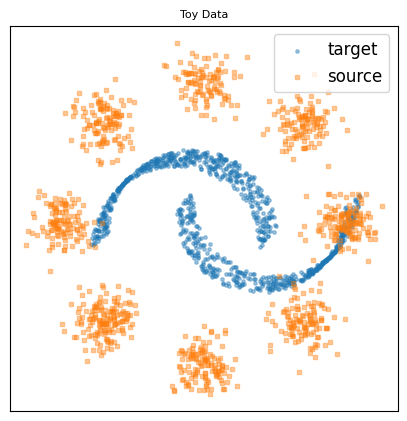

In [1]:
import matplotlib.pyplot as plt
from cmb.configs.experiments import Configs
from cmb.datasets.toys import SampleCoupling

config = Configs('configs_0.yaml')
toys = SampleCoupling(config=config.data)

_, ax = plt.subplots(1, 1, figsize=(5,5)) 

toys.target.display(num_points=1000, s=6, cmap='tab10', alpha=0.4, ax=ax, label='target')
toys.source.display(num_points=1000, s=6, marker='s', cmap='tab10', alpha=0.4, ax=ax, label='source')

plt.legend(fontsize=12)
plt.title('Toy Data', fontsize=8)
plt.show()

In [2]:
from cmb.dynamics.cfm import  ConditionalFlowMatching
from cmb.models.architectures.deep_nets import MLP
from cmb.models.trainers import CMBTrainer

dynamics = ConditionalFlowMatching(config)
mlp = MLP(config)
model = CMBTrainer(config, dynamics, mlp, toys)
model.train()

2024-09-22 12:41:54.653781: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 12:41:54.696740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 12:41:54.697527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 12:41:55.433725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 70000, validation size: 0, testing sizes: 0


number of training parameters: 37554
start training...


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
from cmb.models.pipelines import Pipeline

pipeline = Pipeline(trained_model=model, config=config)
test = SampleCoupling(config=config.data)
pipeline.generate_samples(source_continuous=test.source.continuous)


/home/df630/CMB/src/cmb/datasets/toys.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions * 3 - 1, torch.tensor(labels, dtype=torch.long)
/home/df630/CMB/src/cmb/datasets/toys.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return positions, torch.tensor(labels, dtype=torch.long)


### CFM: 
- $q(x_0, x_1)=q_0(x_0)\cdot q_1(x_1)$
- $\sigma_{CFM}=0.1$

/tmp/ipykernel_1832586/1844071637.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[j].scatter(paths[idx_path, :N, 0], paths[idx_path, :N, 1], s=1, c=color, cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)


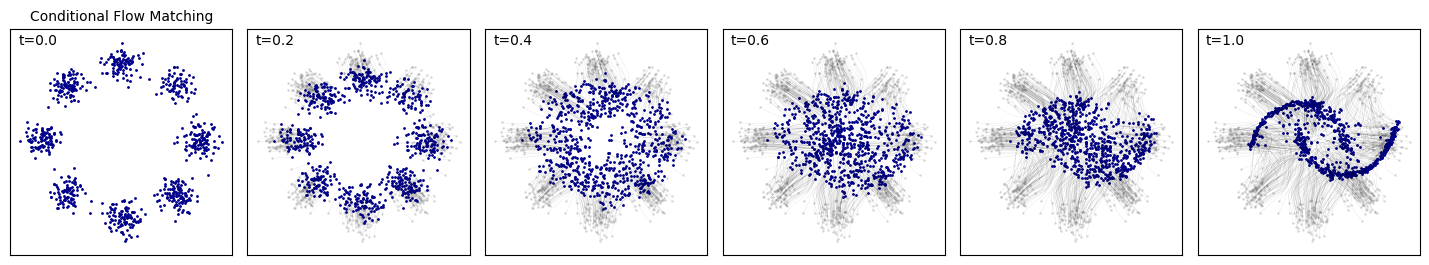

In [8]:
from utils import plot_trajectories


plot_trajectories(pipeline.paths, 
                  title='Conditional Flow Matching', 
                  N=800, 
                  show_paths=True)

- $q(x_0, x_1)=q_0(x_0)\cdot q_1(x_1)$
- $\sigma_{CFM}=10^{-5}$

/home/df630/CMB/experiments/gaussians/utils.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[j].scatter(paths[idx_path, :N, 0], paths[idx_path, :N, 1], s=1, c=color, cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)


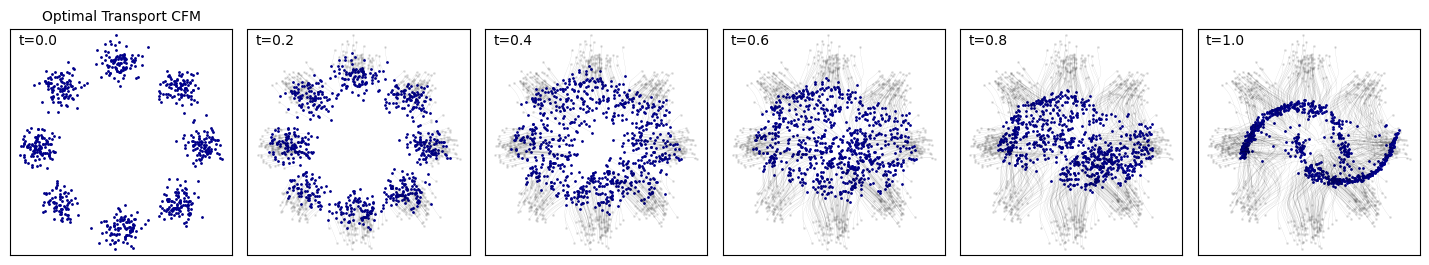

In [4]:
from utils import plot_trajectories


plot_trajectories(pipeline.paths, 
                  title='Optimal Transport CFM', 
                  N=800, 
                  show_paths=True)